In [96]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

from tqdm import tqdm

In [97]:
def exact_solution(d, w0, t):
    w = np.sqrt(w0**2-d**2)
    phi = np.arctan(-d/w)
    u = torch.exp(-d*t)*torch.cos(phi+w*t) / np.cos(phi)
    return u

In [98]:
class FullyConnectedNN(nn.Module):

    def __init__(self, hidden_layers):
        super().__init__()
        layers = []
        n_hidden_layers = len(hidden_layers)
        in_ = 1
        for i in range(n_hidden_layers):
            out_ = hidden_layers[i]
            layer_ = nn.Sequential(nn.Linear(in_, out_), nn.Tanh())
            in_ = out_
            layers.append(layer_)
        layers.append(nn.Linear(in_, 1))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)


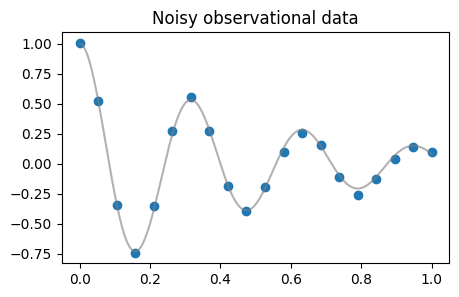

In [111]:
# first, create some noisy observational data
torch.manual_seed(123)

d, w0 = 2, 20
mu_true = 2*d
n_observations = 20

# Exact solution
t_test = torch.linspace(0,1,300).view(-1,1)
u_exact = exact_solution(d, w0, t_test)

# Noisy Observations
noise_level = 0.02
t_obs = torch.linspace(0,1,n_observations).view(-1,1)
u_obs = exact_solution(d, w0, t_obs) + noise_level*torch.randn_like(t_obs)

plt.figure(figsize=(5,3))
plt.title("Noisy observational data")
plt.scatter(t_obs[:,0], u_obs[:,0])
plt.plot(t_test[:,0], u_exact[:,0], label="Exact solution", color="tab:grey", alpha=0.6)
plt.show()

In [112]:
def lossfun(pinn_model, t_physics, t_observations, u_observations, lambda_obs):
    u = pinn_model(t_physics)
    dudt = torch.autograd.grad(u, t_physics, torch.ones_like(u), create_graph=True)[0]
    d2udt2 = torch.autograd.grad(dudt, t_physics, torch.ones_like(dudt), create_graph=True)[0]
    loss_ode = torch.mean((d2udt2 + mu*dudt + k*u)**2)
    # Observations loss
    u = pinn(t_observations)
    loss_observations = torch.mean((u - u_observations)**2)
    loss = loss_ode + lambda_obs*loss_observations
    return loss

In [113]:
torch.manual_seed(123)
pinn = FullyConnectedNN([32, 128, 32])
t_physics = torch.linspace(0, 1, 50).view(-1,1).requires_grad_(True)

# Known parameters
w0 = 20
k = w0**2
lambda1 = 1e4
n_epochs = 20000

# treat mu as a learnable parameter
mu = nn.Parameter(torch.zeros(1, requires_grad=True))
mu_cache = torch.zeros(n_epochs)

# add mu to the optimiser
optimiser = torch.optim.Adam(list(pinn.parameters())+[mu], lr=1e-3)
for i in tqdm(range(n_epochs), desc="Training PINN"):
    optimiser.zero_grad()
    loss = lossfun(pinn, t_physics, t_obs, u_obs, lambda1)
    loss.backward()
    optimiser.step()
    mu_cache[i] = mu.item()

Training PINN: 100%|██████████| 20000/20000 [00:17<00:00, 1145.87it/s]


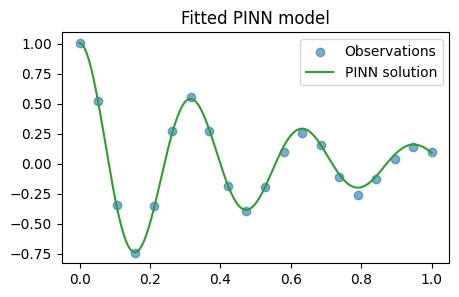

In [114]:
u = pinn(t_test).detach()
plt.figure(figsize=(5, 3))
plt.scatter(t_obs[:,0], u_obs[:,0], label="Observations", alpha=0.6)
plt.plot(t_test[:,0], u[:,0], label="PINN solution", color="tab:green")
plt.title("Fitted PINN model")
plt.legend()
plt.show()

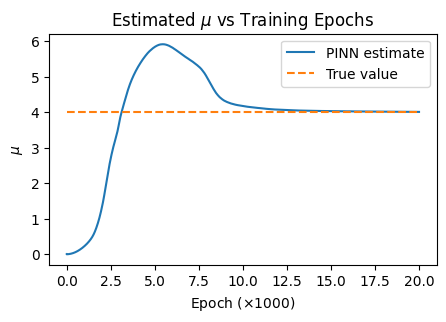

In [120]:
plt.figure(figsize=(5, 3))
plt.title("Estimated $\\mu$ vs Training Epochs")
plt.plot(np.arange(n_epochs)/1000, mu_cache, label="PINN estimate")
plt.plot([0, n_epochs/1000], [2*d, 2*d], '--', label="True value")
plt.legend()
plt.xlabel("Epoch ($\\times 1000$)"); plt.ylabel("$\\mu$")
plt.show()